In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:18<00:00, 31.4MB/s]

Extracting files...


Path to dataset files: /Users/giuliasaresini/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


# **DATA LOADING AND NORMALIZATION**

In [3]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score
from torchsummary import summary
import math

In [34]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 244

def get_training_data(data_dir):
    data = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                # Load and resize the image
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize the image
                
                # Add the image and label as a pair
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    
    # Convert the list to a NumPy array
    data = np.array(data, dtype=object)  # Use dtype=object to allow image-label pairing
    return data

# Load the data
train_data = get_training_data('/Users/giuliasaresini/Documents/tesi_vs/Medicine/Progetto/data/chest_xray/train')
test_data = get_training_data('/Users/giuliasaresini/Documents/tesi_vs/Medicine/Progetto/data/chest_xray/test')
val_data = get_training_data('/Users/giuliasaresini/Documents/tesi_vs/Medicine/Progetto/data/chest_xray/val')

## **NORMALIZE DATA**

In [35]:
from sklearn.utils import shuffle

# Function to normalize the images
def normalize_images(data):
    images = []
    labels = []
    
    for img, label in data:
        # Normalization: each pixel is divided by 255
        normalized_img = img / 255.0
        images.append(normalized_img)
        labels.append(label)
    
    # Convert the images and labels into separate arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Normalize the images in the training dataset
train_images, train_labels = normalize_images(train_data)
val_images, val_labels = normalize_images(val_data)
test_images, test_labels = normalize_images(test_data)

# Shuffle the training and validation data
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
val_images, val_labels = shuffle(val_images, val_labels, random_state=42)

# Check the shape and an example of the normalized and shuffled data
print(f"Shape of normalized and shuffled train images: {train_images.shape}")
print(f"Shape of normalized and shuffled validation images: {val_images.shape}")

Shape of normalized and shuffled train images: (6214, 244, 244)
Shape of normalized and shuffled validation images: (1046, 244, 244)


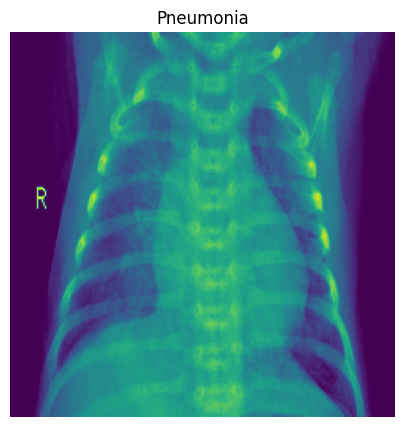

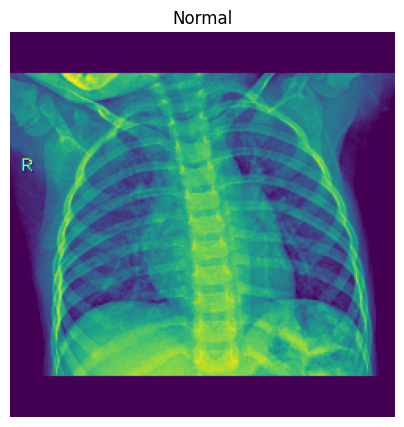

In [36]:
# Separate the images and the labels
train_images = np.array([x[0] for x in train_data])  # Extract only the images
train_labels = np.array([x[1] for x in train_data])  # Extract only the labels

# Display the first image
plt.figure(figsize=(5, 5))
plt.imshow(train_images[0])  # The first image
plt.title('Pneumonia' if train_labels[0] == 0 else 'Normal')  # Set the title based on the label
plt.axis('off')  # To hide the axes
plt.show()

# Display the last image
plt.figure(figsize=(5, 5))
plt.imshow(train_images[-1])  # The last image
plt.title('Pneumonia' if train_labels[-1] == 0 else 'Normal')  # Set the title based on the label
plt.axis('off')  # To hide the axes
plt.show()

# **KAN REAL**

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score
from torchsummary import summary
import math

# KANLinear_v1 Class (Custom Layer)
class KANLinear_v1(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, 
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0, 
                 enable_standalone_scale_spline=True, base_activation=nn.SiLU, 
                 grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear_v1, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h 
                 + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 0.5)
                     * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_(
                self.scale_spline * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise)
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x):
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, :-(k+1)]) / (grid[:, k:-1] - grid[:, :-(k+1)]) * bases[:, :, :-1]
                     + (grid[:, k+1:] - x) / (grid[:, k+1:] - grid[:, 1:-k]) * bases[:, :, 1:])
        return bases.contiguous()

    def curve2coeff(self, x, y):
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        return solution.permute(2, 0, 1).contiguous()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1), 
            self.spline_weight.view(self.out_features, -1)
        )
        return base_output + spline_output

# ConvNeXtKAN_v1 Model
class ConvNeXtKAN_v1(nn.Module):
    def __init__(self):
        super(ConvNeXtKAN_v1, self).__init__()
        # Base model
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),  # First convolutional layer: 1 Gray channels
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),  # Second convolutional layer
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),  # Third convolutional layer
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),  # Fourth convolutional layer
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling

            nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to reduce the size
        )

        self.flatten = nn.Flatten()

        # KAN layers
        self.kan1 = KANLinear_v1(256, 512)
        self.kan2 = KANLinear_v1(512, 2)  # 2 classes (suitable for binary classification)

    def forward(self, x):
        x = self.conv_layers(x)  # Pass through convolutions
        x = self.flatten(x)  # Flatten the output
        x = self.kan1(x)  # Pass through the first KAN layer
        x = self.kan2(x)  # Pass through the second KAN layer
        return x

# Print the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNeXtKAN_v1().to(device)

# Print a summary of the model for 1x244x244 images (Grayscale)
summary(model, (1, 244, 244))

# Define the AdamW optimizer with L2 regularization
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Function to monitor precision and recall
def calculate_precision_recall(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    #precision = precision_score(all_labels, all_preds, average='binary', zero_division=1)
    #recall = recall_score(all_labels, all_preds, average='binary', zero_division=1)

    return precision, recall

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 244, 244]             288
       BatchNorm2d-2         [-1, 32, 244, 244]              64
              ReLU-3         [-1, 32, 244, 244]               0
         MaxPool2d-4         [-1, 32, 122, 122]               0
            Conv2d-5         [-1, 64, 122, 122]          18,432
       BatchNorm2d-6         [-1, 64, 122, 122]             128
              ReLU-7         [-1, 64, 122, 122]               0
         MaxPool2d-8           [-1, 64, 61, 61]               0
            Conv2d-9          [-1, 128, 61, 61]          73,728
      BatchNorm2d-10          [-1, 128, 61, 61]             256
             ReLU-11          [-1, 128, 61, 61]               0
        MaxPool2d-12          [-1, 128, 30, 30]               0
           Conv2d-13          [-1, 256, 30, 30]         294,912
      BatchNorm2d-14          [-1, 256,

In [37]:
from collections import Counter

# Contare la distribuzione delle etichette
distribution = Counter(val_labels)
print(distribution)


Counter({0: 776, 1: 270})


In [38]:
from collections import Counter

# Contare la distribuzione delle etichette
distribution = Counter(train_labels)
print(distribution)


Counter({0: 3107, 1: 3107})


In [43]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Apply the transformation to training and validation images
train_images_tensor = torch.stack([torch.tensor(img) for img in train_images]).unsqueeze(1)
val_images_tensor = torch.stack([torch.tensor(img) for img in val_images]).unsqueeze(1)

# Now permute them
train_images_tensor = train_images_tensor.permute(0, 1, 2, 3)  # (N, 1, 244, 244)
val_images_tensor = val_images_tensor.permute(0, 1, 2, 3)      # (N, 1, 244, 244)
print(val_images_tensor.shape, train_images_tensor.shape)

# The tensors are now in the shape (N, 1, 244, 244), where N is the number of images

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long) 
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long) 

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)

# Define the batch size
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
print('train')
for i, (img,labels) in enumerate(val_loader):
    if i == 10:
        break        
    print(labels)

torch.Size([1046, 1, 244, 244]) torch.Size([6214, 1, 244, 244])
train
tensor([0, 0, 0, 0, 1, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 1, 0, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1])
tensor([0, 1, 0, 1, 0, 0, 0, 0])


In [40]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Apply the transformation to training and validation images
train_images_tensor = torch.stack([torch.tensor(img) for img in train_images]).unsqueeze(1)
val_images_tensor = torch.stack([torch.tensor(img) for img in val_images]).unsqueeze(1)

# Now permute them
train_images_tensor = train_images_tensor.permute(0, 1, 2, 3)  # (N, 1, 244, 244)
val_images_tensor = val_images_tensor.permute(0, 1, 2, 3)      # (N, 1, 244, 244)
print(val_images_tensor.shape, train_images_tensor.shape)

# The tensors are now in the shape (N, 1, 244, 244), where N is the number of images

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long) 
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long) 

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)

# Define the batch size
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
print('train')
for i, (img,labels) in enumerate(train_loader):
    if i == 10:
        break        
    print(labels)
    
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model and device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNeXtKAN_v1().to(device)

# Define the loss function and optimizer (AdamW + L2 regularization)
criterion = nn.CrossEntropyLoss()  # For multi-class or binary classification
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # AdamW with L2 regularization

# Now the data is ready for training and validation

# Function to calculate precision and recall
def calculate_precision_recall(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    
    return precision, recall

# Training function with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10):
    #best_val_accuracy = 0.0
    best_val_loss = float("inf")
    epochs_without_improvement = 0  # Count the number of epochs without improvement

    for epoch in range(num_epochs):
        model.train()  # Training mode
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(torch.float32).to(device), labels.to(torch.long).to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Compute metrics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")

        # Validation phase
        model.eval()  # Evaluation mode
        val_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(torch.float32).to(device), labels.to(torch.long).to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute the loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Compute metrics
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels).item()
                val_total_preds += labels.size(0)

        # Calculate validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct_preds / val_total_preds

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Calculate precision and recall on validation
        val_precision, val_recall = calculate_precision_recall(model, val_loader, device)
        print(f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")

        # Early Stopping: stop if no improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            #best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            # Save the model with the best validation loss
            torch.save(model.state_dict(), "best_model_v2.pth")
            print("Model saved!")
        else:
            epochs_without_improvement += 1
            print(f"Early Stopping Counter: {epochs_without_improvement}/{patience}")

        # If the number of epochs without improvement exceeds patience, stop
        if epochs_without_improvement >= patience:
            print("Early stopping triggered. Stopping training.")
            break

# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10)

torch.Size([1046, 1, 244, 244]) torch.Size([6214, 1, 244, 244])
train


KeyboardInterrupt: 

In [29]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score


# Convert them to tensors if they aren't already
test_images_tensor = torch.stack([torch.tensor(img) for img in test_images]).unsqueeze(1)  # Applying the same transformation as for train/val
test_images_tensor = test_images_tensor.permute(0, 1, 2, 3)
print(test_images_tensor.shape)

test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)  # or torch.float if binary classification

# Create the dataset and DataLoader for the test set
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Function to calculate precision, recall, F1-score, and accuracy on a dataset
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to calculate precision, recall, F1-score, and accuracy on a dataset
def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            
            # Calculate correct predictions
            correct_preds += torch.sum(preds == target).item()
            total_preds += target.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    # Calculate the metrics
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = correct_preds / total_preds  # Accuracy

    return precision, recall, f1, accuracy

# Test the model on the test data
def test_model(model, test_loader, device):
    precision, recall, f1, accuracy = calculate_metrics(model, test_loader, device)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

# Load the saved model (if you've already trained the model)
model = ConvNeXtKAN_v1().to(device)
model.load_state_dict(torch.load("best_model_v2.pth"))  # Load the model with the best result

# Run the test
test_model(model, test_loader, device)

torch.Size([624, 1, 244, 244])


/var/folders/tj/7m7f0dn51772hz65_qmb34940000gn/T/ipykernel_81494/1020254551.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model

Test Accuracy: 0.8750
Test Precision: 0.9105
Test Recall: 0.7393
Test F1-Score: 0.8160
